Download and crop images

In [1]:
# Provided by ChatGPT
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os

def download_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")
        return None

def crop_and_save_image(image, bbox, save_path):
    width, height = image.size
    left = bbox[0] * width
    top = bbox[2] * height
    right = bbox[1] * width
    bottom = bbox[3] * height
    
    cropped_image = image.crop((left, top, right, bottom))
    cropped_image.save(save_path)

def process_csv(file_path, output_dir):
    # Read the first 10 lines of the CSV file
    df = pd.read_csv(file_path, header=None, nrows=10)
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        for i in range(0, len(row) - 5, 5):
            url = row[i]
            # Ensure the value is a string before checking if it is a valid URL
            if not isinstance(url, str) or not url.startswith("http"): 
                print(f"Skipping invalid URL: {url}")
                continue
            
            bbox = [row[i+1], row[i+2], row[i+3], row[i+4]]
            
            # Download the image
            image = download_image(url)
            if image is None:
                continue
            
            # Create output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)
            
            # Define save path for cropped image
            save_path = os.path.join(output_dir, f"cropped_face_{index}_{i//5}.jpg")
            
            # Crop and save the image
            crop_and_save_image(image, bbox, save_path)
            print(f"Saved cropped face to {save_path}")





# if __name__ == "__main__":
#     # Path to your CSV file
#     csv_file_path = "./FEC_dataset/faceexp-comparison-data-train-public.csv"
#     # Directory to save cropped face images
#     output_directory = "cropped_faces"
    
#     process_csv(csv_file_path, output_directory)

Load Grayscale image and 2D fourier transform it

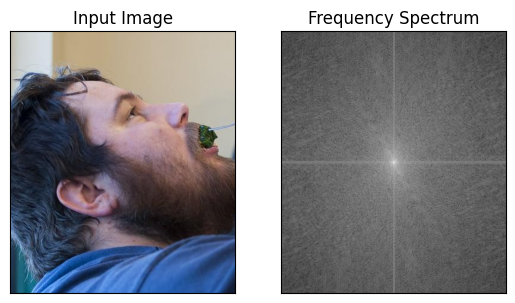

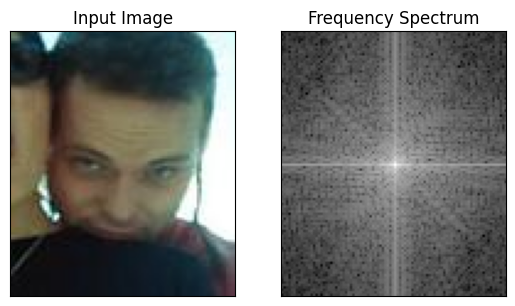

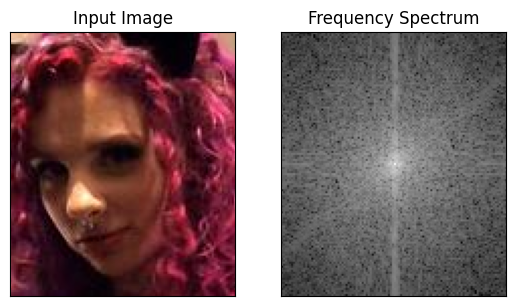

In [2]:
from PIL import Image
import PIL
import PIL.ImageOps
import numpy as np
from matplotlib import pyplot as plt

def transform_and_plot_image(path: str):
    img = Image.open(path)
    grayscale = PIL.ImageOps.grayscale(img)
    # grayscale.show()
    fourier_transformed = np.fft.fft2(grayscale)
    fourier_transformed_shifted = np.fft.fftshift(fourier_transformed)
    magnitude_spectrum = 20 * np.log(np.abs(fourier_transformed_shifted))
    
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return grayscale, fourier_transformed_shifted

grayscale_1, fourier_transformed_1 = transform_and_plot_image("./cropped_faces/cropped_face_6_1.jpg")
grayscale_2, fourier_transformed_2 = transform_and_plot_image("./cropped_faces/cropped_face_9_1.jpg")
grayscale_3, fourier_transformed_3 = transform_and_plot_image("./cropped_faces/cropped_face_3_1.jpg")

Low pass filter

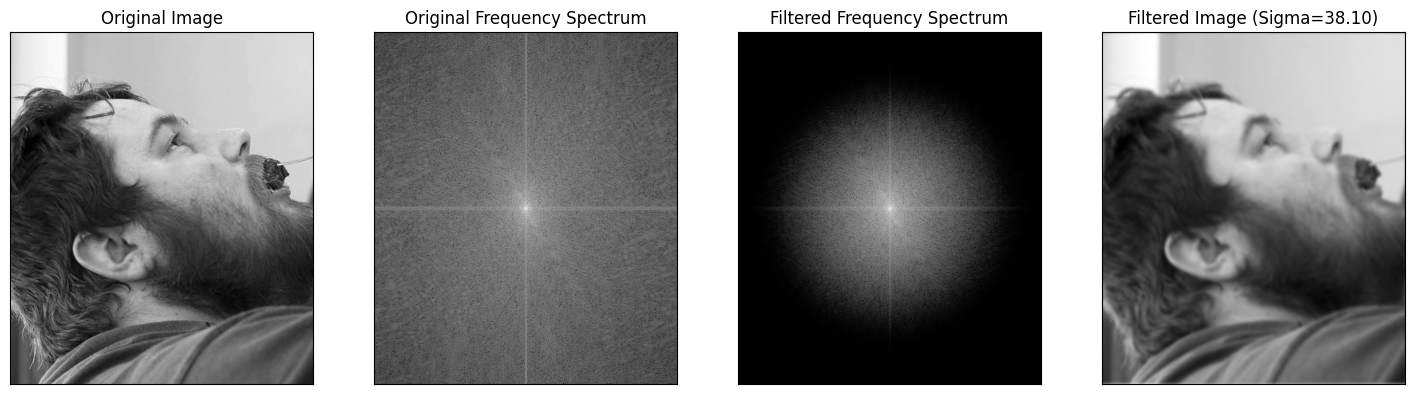

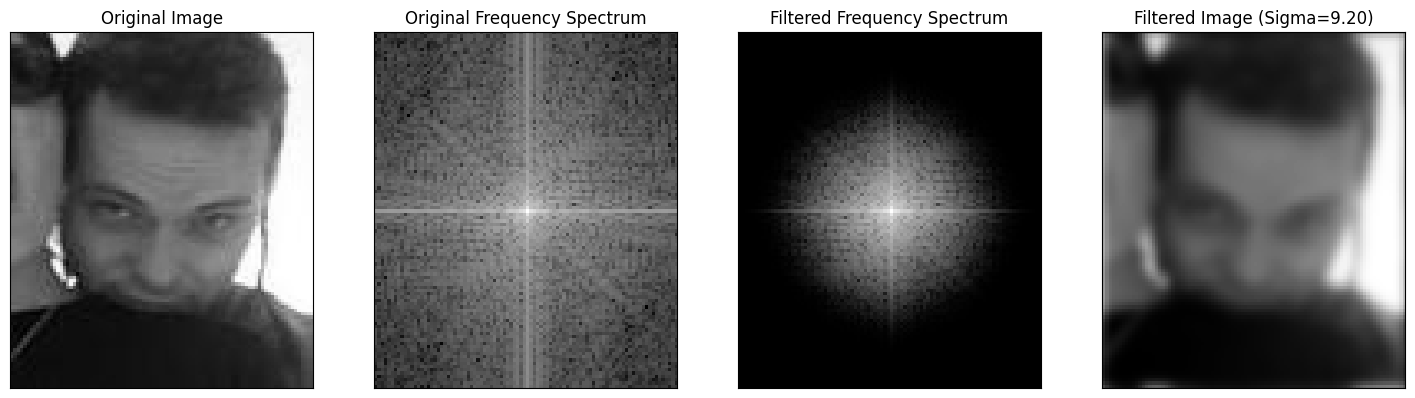

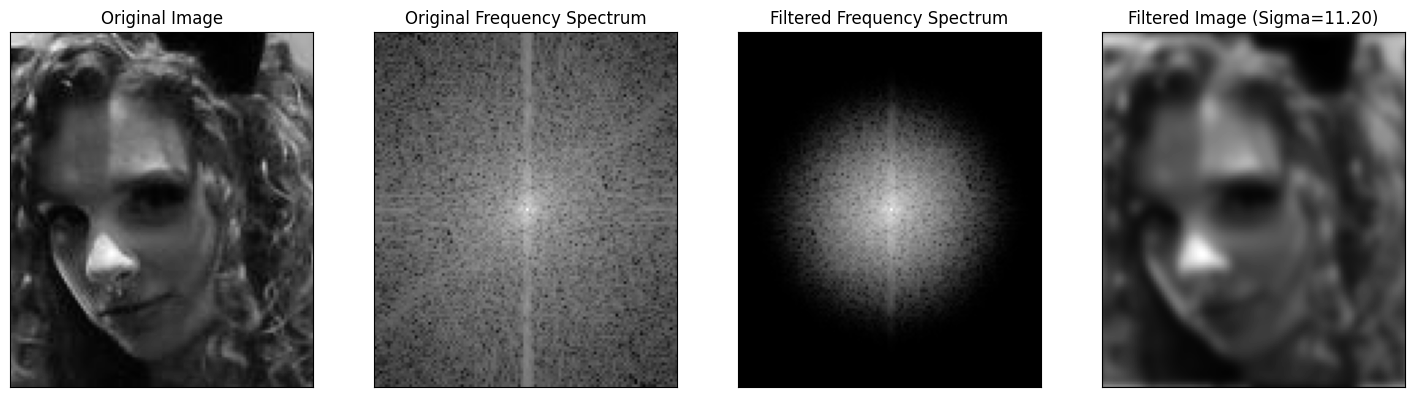

In [3]:
import numpy as np
import cv2
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt

def apply_low_pass_filter_and_plot(grayscale, fourier_transformed, scaling_factor=0.1):
    # Convert grayscale image to numpy array
    img_np = np.array(grayscale)
    
    # Use the provided Fourier transformed image
    dft_shifted = fourier_transformed
    
    # Get image dimensions
    rows, cols = img_np.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image
    
    # Calculate sigma for Gaussian based on image size and scaling factor
    sigma = min(rows, cols) * scaling_factor
    
    # Create a Gaussian low-pass filter (mask)
    x = np.linspace(-ccol, ccol, cols)
    y = np.linspace(-crow, crow, rows)
    x, y = np.meshgrid(x, y)
    
    # Gaussian function
    gaussian_mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # Apply the Gaussian mask (low-pass filter)
    dft_shifted_filtered = dft_shifted * gaussian_mask
    
    # Inverse DFT to get the filtered image
    dft_inverse = np.fft.ifftshift(dft_shifted_filtered)  # Shift back the zero frequency
    img_filtered = np.fft.ifft2(dft_inverse)
    img_filtered = np.abs(img_filtered)
    
    # Plot the results
    plt.figure(figsize=(18, 6))
    
    # Original Image
    plt.subplot(141), plt.imshow(grayscale, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    # Frequency Spectrum (Magnitude) - Original
    magnitude_spectrum = 20 * np.log(np.abs(dft_shifted))
    plt.subplot(142), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Original Frequency Spectrum'), plt.xticks([]), plt.yticks([])

    # Frequency Spectrum (Magnitude) - After Low Pass Filter
    filtered_magnitude_spectrum = 20 * np.log(np.abs(dft_shifted_filtered) + 1)  # Add 1 to avoid log(0)
    plt.subplot(143), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
    plt.title('Filtered Frequency Spectrum'), plt.xticks([]), plt.yticks([])

    # Filtered Image
    plt.subplot(144), plt.imshow(img_filtered, cmap='gray')
    plt.title(f'Filtered Image (Sigma={sigma:.2f})'), plt.xticks([]), plt.yticks([])

    plt.show()

# Apply the function to an image
apply_low_pass_filter_and_plot(grayscale_1, fourier_transformed_1, 0.10)
apply_low_pass_filter_and_plot(grayscale_2, fourier_transformed_2, 0.10)
apply_low_pass_filter_and_plot(grayscale_3, fourier_transformed_3, 0.10)

Compression

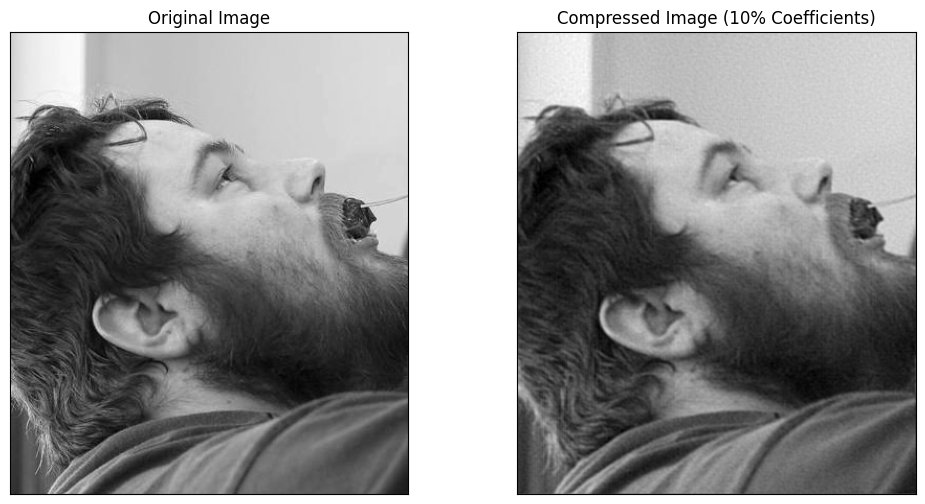

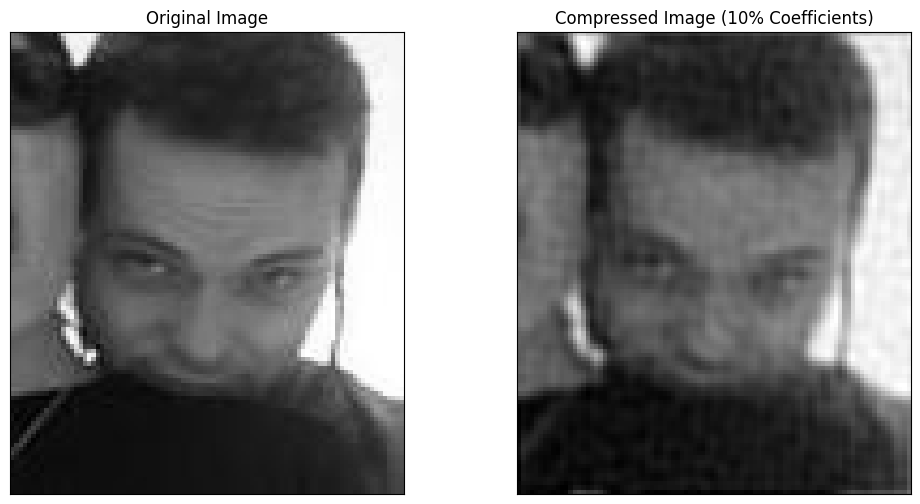

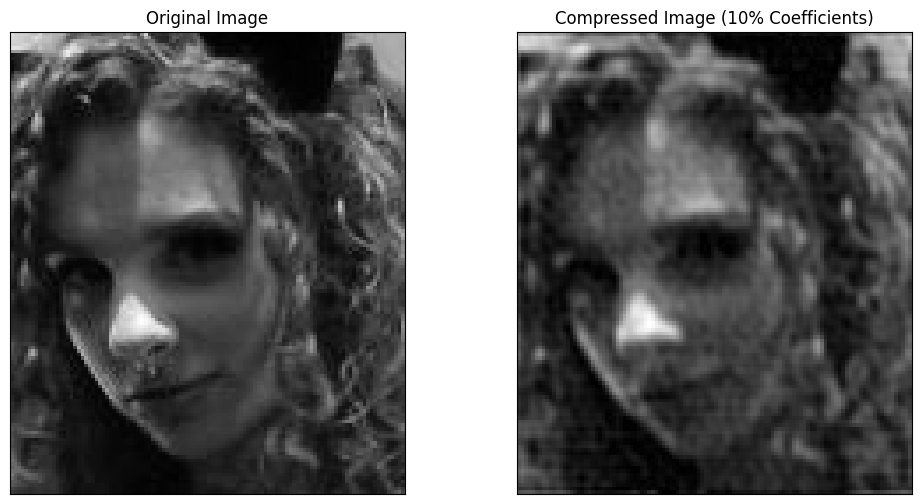

In [8]:
import numpy as np
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt

def compress_image_using_fourier(grayscale, fourier_transformed, percentage: float):
    # Convert grayscale image to numpy array
    img_np = np.array(grayscale)
    
    # Use the provided Fourier transformed image
    dft_shifted = fourier_transformed
    
    # Flatten and sort the Fourier coefficients by magnitude
    magnitude = np.abs(dft_shifted)
    flat_magnitude = magnitude.flatten()
    sorted_indices = np.argsort(flat_magnitude)[::-1]  # Sort from largest to smallest
    
    # Determine how many coefficients to retain based on the percentage
    total_coefficients = len(flat_magnitude)
    num_coefficients_to_keep = int(total_coefficients * percentage / 100)
    
    # Create a mask that retains only the top coefficients by magnitude
    mask = np.zeros_like(flat_magnitude)
    mask[sorted_indices[:num_coefficients_to_keep]] = 1
    mask = mask.reshape(dft_shifted.shape)  # Reshape to original Fourier transform shape
    
    # Apply the mask to the Fourier transformed image
    dft_shifted_compressed = dft_shifted * mask
    
    # Inverse DFT to get the compressed image
    dft_inverse = np.fft.ifftshift(dft_shifted_compressed)
    img_compressed = np.fft.ifft2(dft_inverse)
    img_compressed = np.abs(img_compressed)
    
    plt.figure(figsize=(12, 6))
    
    # Plot Original Image
    plt.subplot(121), plt.imshow(grayscale, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    # Plot Compressed Image
    plt.subplot(122), plt.imshow(img_compressed, cmap='gray')
    plt.title(f'Compressed Image ({percentage}% Coefficients)'), plt.xticks([]), plt.yticks([])

    plt.show()

# Apply the compression function to all images
compress_image_using_fourier(grayscale_1, fourier_transformed_1, 10)  # Adjust here to change the percentage retained
compress_image_using_fourier(grayscale_2, fourier_transformed_2, 10)
compress_image_using_fourier(grayscale_3, fourier_transformed_3, 10)